# Natural Language Processing

## Part 2: TorchText + Padded

Here we shall improve the previous one by adding:

Improve the learning
- pre-trained word embeddings (**) (improve accuracy by around 20)
- changed optimizer to Adam (make the thing learn faster)
- orthogonal initialization (not significant improvements but certainly the choice in RNN/LSTM or even CNN!)


Improve efficiency
- packed padded sequences in RNN to save computations and also ask the RNN to ignore padding (++) (this is the deal breaker; without this, my accuracy is 25) (https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)
- put padding_idx in embedding layer to save computations (no hit to accuracy but good practice to do)

In [1]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [8]:
#let's change the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

{1, 2, 3, 4}

In [9]:
train_size = len(list(iter(train)))
train_size

120000

Since 120000 gonna just take up too much of our GPU, and also for the sake of learning, we gonna resize it.....  All `DataPipe` instance has a handy function called `random_split`

In [10]:
too_much, train, valid = train.random_split(total_length=train_size, weights = {"too_much": 0.7, "smaller_train": 0.2, "valid": 0.1}, seed=999)

In [11]:
train_size = len(list(iter(train)))
train_size

24000

In [12]:
val_size = len(list(iter(valid)))
val_size

12000

In [13]:
test_size = len(list(iter(test)))
test_size

7600

## 3. Preprocessing 

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [14]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

### Text to integers (numeral)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [15]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [16]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[509, 27, 9, 0, 9]

In [17]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'here'

In [18]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [19]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [20]:
#so we can 50k+ unique vocabularies!
len(vocab)

52828

## 4. FastText Embeddings

We will first download the pre-trained vectors, here I am using FastText.  Then we will get all the FastText embeddings that exist in the vocab.  

**Small Intro to Embeddings**

1. *Word2Vec* - the first efficient word embedding, trained on Continuous Bag-of-words (CBOW) and SkipGram (SG).  The limitations include: (1) works only with local window information, not the whole document, (2) no subword information (prefix, suffix, etc.), (3) cannot handle OOV words, and (4) do not handle context.

First three problems were addressed by GloVe and FastText, and last one has been resolved by Elmo and BERT.

<img src = "figures/word2vec.png" width=300>

2. *GloVe* - particularly adresses problem no. 1 which uses co-occurrence statistics of the whole corpus.  For example, given words i=ice, j=steam, we want to study a ratio of occurrence probabilities with some probe word k=solid as this figure:

<img src = "figures/glove.png" width=300>

3. *FastText* - addresses problem no. 2 and 3.  Uses the skipgram arhitecture to train but with the following improvements:  (1) faster and simpler to train, (2) consider subwords as ngrams (If we consider the word “what” and use n=3 or tri-grams, the word would be represented by the character n-grams: <”wh”,”wha”,”hat”,”at”>. < and > are special symbols that are added at the start and end of each word.), (3) it can generate embeddings from OOV thanks to the ngrams.  An OOV word vector can be built with the average vector representation of its n-grams.     Big disadvantage is its high memory requirements.

4. *ElMo* - given same word "stick" can have different meanings.  By using a bi-directional LSTM, ElMo was able to understand not only the next words, but also the preceding ones.  Also can work like FastText on subwords and do not suffer OOV problem.

In [21]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [22]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [23]:
fast_embedding.shape   #we have X vocabs, each with a 300 fasttext embedding

torch.Size([52828, 300])

## 5. Preparing the dataloader

In torchtext, first thing before the batch iterator is to define how you want to process your text and label.  

In [24]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

Let's look at example how it looks

In [25]:
text_pipeline("I love to play football")

[275, 4021, 8, 389, 574]

In [26]:
label_pipeline('1')

0

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.  **We gonna add length of the sequence since packed padded sequences require this.**

In [27]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))  #++<-----packed padded sequences require 
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list,  padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

Create train, val, and test dataloaders

In [28]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.  Note that {“World”, “Sports”, “Business”, “Sci/Tech”} maps to {0, 1, 2, 3}

In [29]:
for label, text, length in train_loader:
    break

In [30]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 138])


## 6. Design the model

An addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the `hidden` states (hidden states are tensors while output is in packed form). Without packed padded sequences, `hidden` is tensor from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. 

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of `output` from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

### About pack padded sequence

By packing the padded sequence, the RNN (RNN, LSTM, GRU) does not need to do unnecessary computations.

In [31]:
a = [torch.tensor([1,2,3]), torch.tensor([3,4])]
b = torch.nn.utils.rnn.pad_sequence(a)
b

tensor([[1, 3],
        [2, 4],
        [3, 0]])

In [32]:
c = torch.nn.utils.rnn.pack_padded_sequence(b, lengths=[3,2])

Now that we understand, we are ready to define the model

In [33]:
import torch.nn as nn

class paddedRNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_dim, hid_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)
        
    def forward(self, text, text_lengths):
        #about packing-unpacking: https://gist.github.com/MikulasZelinka/9fce4ed47ae74fca454e88a39f8d911a
            
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first = True, enforce_sorted=False)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, hn = self.rnn(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first = True)
        
        #output = [batch size, seq len, hidden dim]
        #hidden = [1, batch size, hidden dim]
        
        return self.fc(hn.squeeze(0))

### Let's see how each layer works

In [34]:
label, text, length = next(iter(train_loader))

In [35]:
input_dim  = len(vocab)
emb_dim    = 300         #**<----change to 300
hid_dim    = 256

embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)

In [36]:
embedded = embedding(text)

In [37]:
embedded.shape #embedded = [batch size, seq len, embed dim]

torch.Size([64, 163, 300])

In [38]:
packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, enforce_sorted=False)

In [39]:
packed_embedded

PackedSequence(data=tensor([[-0.3035, -0.8574, -1.4803,  ..., -0.8621, -2.2920,  1.1279],
        [-1.3008, -1.2612,  0.7807,  ..., -0.8144, -0.2199,  0.7117],
        [-1.9198, -1.6360,  0.8086,  ..., -1.0953,  1.2250, -0.8692],
        ...,
        [ 0.5710,  0.0725, -1.0540,  ..., -0.0708,  0.1073, -0.6889],
        [-1.5579,  0.2799, -0.0213,  ...,  0.7043, -1.1739,  0.5510],
        [-1.5690,  0.9199,  0.2268,  ...,  0.5839,  0.0341, -0.1456]],
       grad_fn=<PackPaddedSequenceBackward0>), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 63, 63, 63, 63, 62, 60, 59, 59, 58, 58, 58, 57, 56, 54, 53, 53, 52,
        50, 49, 48, 46, 46, 46, 43, 42, 39, 38, 38, 35, 30, 27, 26, 23, 20, 11,
        10,  9,  9,  7,  7,  7,  6,  5,  5,  4,  4,  4,  4,  4,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
       

In [40]:
rnn = nn.RNN(emb_dim, hid_dim, num_layers=1, batch_first=True)

In [41]:
packed_output, packed_hn = rnn(packed_embedded)  #if no h0, all zeroes;  rnn will NOT compute <pad> if it is packed

In [42]:
packed_hn.shape #num_layer, batch_size, hdim          

torch.Size([1, 64, 256])

In [43]:
packed_hn

tensor([[[ 0.3569,  0.5748, -0.5094,  ...,  0.2981, -0.6635, -0.7413],
         [ 0.7986,  0.6382, -0.0642,  ..., -0.0945, -0.6261, -0.3193],
         [ 0.1600,  0.7535, -0.6345,  ..., -0.6416, -0.5695, -0.6803],
         ...,
         [ 0.4538,  0.3041, -0.2385,  ..., -0.1778, -0.3534, -0.3958],
         [ 0.0809,  0.4363, -0.4844,  ...,  0.2668, -0.2473, -0.3607],
         [-0.0154,  0.1545, -0.2761,  ...,  0.1193, -0.4363, -0.5838]]],
       grad_fn=<IndexSelectBackward0>)

In [44]:
output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

In [45]:
output.shape #output = [batch size, seq len, hidden dim]

torch.Size([64, 163, 256])

In [46]:
output  #lots of zeros over padding element

tensor([[[-0.5647,  0.0864,  0.8556,  ..., -0.1255,  0.7156, -0.0869],
         [ 0.7808,  0.4248,  0.9528,  ..., -0.8404,  0.3297,  0.7496],
         [ 0.7918, -0.5955,  0.8315,  ..., -0.7017,  0.2438,  0.0128],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.6871, -0.3017,  0.5292,  ..., -0.3723,  0.1839,  0.8118],
         [-0.0769,  0.7548, -0.8508,  ..., -0.5588,  0.5206,  0.2846],
         [ 0.4414,  0.7381,  0.0267,  ..., -0.1761, -0.4810, -0.5806],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.3066, -0.4459, -0.0981,  ..., -0.1776,  0.1449, -0.3175],
         [-0.7614,  0.5837,  0.1704,  ...,  0

In [47]:
output[:, -1, :]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SliceBackward0>)

In [48]:
packed_hn.squeeze(0)

tensor([[ 0.3569,  0.5748, -0.5094,  ...,  0.2981, -0.6635, -0.7413],
        [ 0.7986,  0.6382, -0.0642,  ..., -0.0945, -0.6261, -0.3193],
        [ 0.1600,  0.7535, -0.6345,  ..., -0.6416, -0.5695, -0.6803],
        ...,
        [ 0.4538,  0.3041, -0.2385,  ..., -0.1778, -0.3534, -0.3958],
        [ 0.0809,  0.4363, -0.4844,  ...,  0.2668, -0.2473, -0.3607],
        [-0.0154,  0.1545, -0.2761,  ...,  0.1193, -0.4363, -0.5838]],
       grad_fn=<SqueezeBackward1>)

In [49]:
#assert torch.equal(output[:, -1, :], packed_hn.squeeze(0)) #they will not be equal

## 7. Training

**Orthogonal initialization**: One of the most extreme issues with recurrent neural networks (RNNs) are vanishing and exploding gradients.  Orthogonal weight matrix is one of the effective way to counter that by using some linear algebra trick, i.e., orthogonal matrix has an eigenvalues of absolute value 1, thus its repeated multiplication will be result in exploding / vanishing gradients.

In [50]:
'''
Example of orthogonal initialization: This can be simply done by using SVD, 
both U and VT are orthogonal, thus both of them can be used as our weight matrix.

As for the shape, we just initialize whatever shape of W want
'''
import numpy as np
X = np.random.random((5, 10))
U, _, Vt = np.linalg.svd(X, full_matrices=False)
print(Vt.shape)
W = Vt

(5, 10)


In [51]:
#eigenvalues of orthogonal matrix are 1
_, eigen_values, _ = np.linalg.svd(U, full_matrices=False)
print(eigen_values)

[1. 1. 1. 1. 1.]


In [52]:
#eigenvalues of orthogonal matrix are 1
_, eigen_values, _ = np.linalg.svd(Vt, full_matrices=False)
print(eigen_values)

[1. 1. 1. 1. 1.]


The repeated multiplication of W can be written like this (let's say power of 2) by putting W in the form of decomposed matrices:

\begin{align*}
W^2 & = (Q \Lambda Q^{-1}) (Q \Lambda Q^{-1}) \\
& = Q \Lambda (Q^{-1} Q) \Lambda Q^{-1} \\
& = Q \Lambda ^ 2 Q^{-1} \\
\end{align*}

As you can see, the repeated multiplication is simply raising the eigenvalues to some power.  Thus whether the repeated multiplication explodes or vanishes can largely depend on the eigenvalues.    

To repeat, since the orthogononal matrix has eigenvalues of absolute value 1, thus its repeated multiplication will alleviate the vanishing/exploding gradients.

In [53]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [54]:
w = torch.empty(3, 5)
nn.init.orthogonal_(w)

tensor([[ 0.6004, -0.7343,  0.0795, -0.2873,  0.1076],
        [-0.5495, -0.1777,  0.0108, -0.7806, -0.2387],
        [ 0.5310,  0.6511, -0.0202, -0.5391,  0.0551]])

**Make sure we use the initialized embedding weight from fasttext**

In [55]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300         #**<----change to 300
output_dim = 4 #four classes

model = paddedRNN(input_dim, emb_dim, hid_dim, output_dim).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [56]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

15848400
 76800
 65536
   256
   256
  1024
     4
______
15992276


In [57]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

#### A bit about Adam

Recall the SGD update rule:

$$\theta = \theta - \alpha\triangledown_\theta J_{\text{minibatch}}(\theta)$$

where $\theta$ is a vector containing all of the model parameters, $J$ is the loss function, $\triangledown_\theta J_{\text{minibatch}}(\theta)$ is the gradient of the loss function, and $\alpha$ is the learning rate.  Adam is another possible update rule with two additional steps.

Adam uses a trick called momentum by keep track of $\mathbf{m}$, a rolling average of the gradients:

$$\mathbf{m} = \beta_1 \mathbf{m} + (1-\beta_1)\triangledown_\theta J_{\text{minibatch}}(\theta)$$
$$\theta = \theta - \alpha \mathbf{m}$$

where $\beta_1$ is a hyperparameter between 0 and 1 (often set to 0.9).  The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions.  Gain faster convergence and reduced oscillation.

Adam further extends the idea of momentum with the trick of adaptive learning rates by keep track of $\mathbf{v}$, a rolling average of the magnitudes of the gradients:

$$\mathbf{m} = \beta_1 \mathbf{m} + (1 - \beta_1)\triangledown_\theta J_{\text{minibatch}}(\theta)$$
$$\mathbf{v} = \beta_2 \mathbf{v} + (1 - \beta_2)(\triangledown_\theta J_{\text{minibatch}}(\theta) \circ \triangledown_\theta J_{\text{minibatch}}(\theta))$$
$$\theta = \theta - \alpha \mathbf{m} \mathbin{/} \sqrt{\mathbf{v}}$$

where $\circ$ and $\mathbin{/}$ denote elementwise multiplication and division (not dot product!).  $\beta_2$ is a hyperparameter between 0 and 1 (often set to 0.99).  Since Adam divides the update by $\sqrt{\mathbf{v}}$, weights that receive high gradients will have their effective learning rate reduced and vice versa for small gradients which will receive increased learning rate. A simple example is let's say $\mathbf{v} = [9, 2, 1]$, its square root is $\sqrt{\mathbf{v}} = [3, \sqrt{2}, 1]$.  Thus by dividing $\mathbf{m}$ by this $\sqrt{\mathbf{v}}$, it is essentially scaling the bigger one to be a bit smaller, and the smaller one will become relatively larger.  This might be helpful because it can get recent stagnant parameters moving more efficiently along their axes and in turn expedite convergence.

In [58]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

**Don't forget to add `text_length`**

In [59]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [60]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Putting everything together

In [61]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [62]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [63]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 9s
	Train Loss: 1.378 | Train Acc: 31.23%
	 Val. Loss: 1.251 |  Val. Acc: 42.20%
Epoch: 02 | Time: 0m 9s
	Train Loss: 1.006 | Train Acc: 55.48%
	 Val. Loss: 0.846 |  Val. Acc: 62.91%
Epoch: 03 | Time: 0m 9s
	Train Loss: 0.815 | Train Acc: 64.70%
	 Val. Loss: 0.784 |  Val. Acc: 67.20%
Epoch: 04 | Time: 0m 9s
	Train Loss: 0.744 | Train Acc: 69.48%
	 Val. Loss: 0.718 |  Val. Acc: 71.41%
Epoch: 05 | Time: 0m 9s
	Train Loss: 0.708 | Train Acc: 72.49%
	 Val. Loss: 0.693 |  Val. Acc: 73.35%


Nice!  Our model is now learning!!

Text(0, 0.5, 'loss')

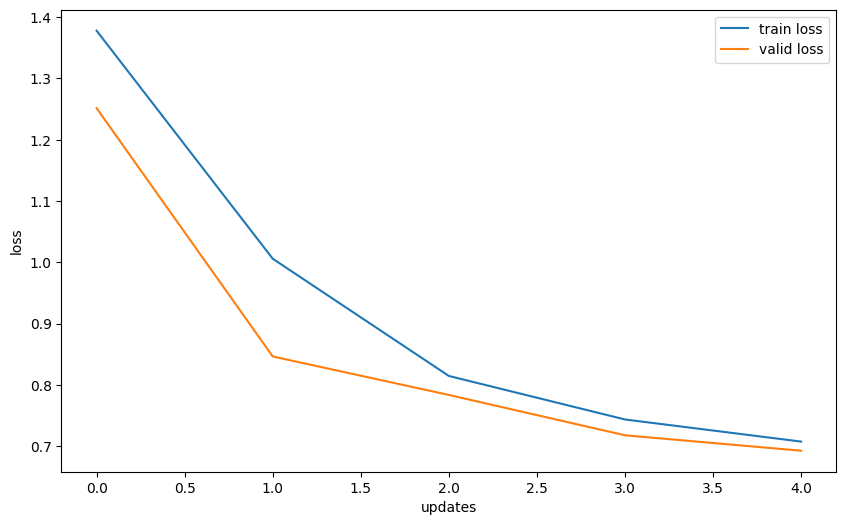

In [64]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

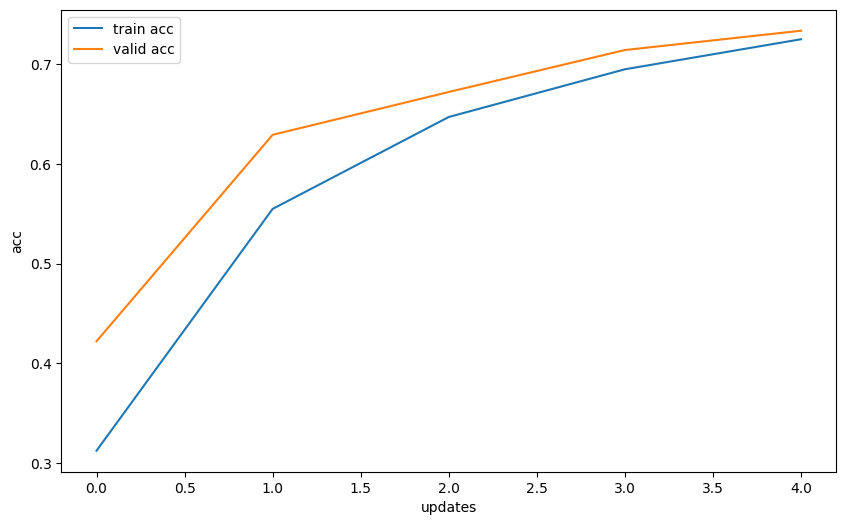

In [65]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [66]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.696 | Test Acc: 73.46%


## 8. Test on some random news

In [67]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  190,    27,   231,  1742, 14918,     6,    16,    21,   358,    27,
         2561,  1316,   231,     6], device='cuda:0')

In [68]:
text_list = [x.item() for x in text]
text_list

[190, 27, 231, 1742, 14918, 6, 16, 21, 358, 27, 2561, 1316, 231, 6]

In [69]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [70]:
text = text.reshape(1, -1)  #because batch_size is 1

In [71]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [72]:
text.shape

torch.Size([1, 14])

In [73]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [74]:
predict(text, text_length)

tensor([3], device='cuda:0')

## Conclusion

### Practice

- Try to turn off FastText embedding and see the accuracy.  For me, the accuracy reduced by around 10 to 20%
- Try to change SGD to Adam.

### Trivials

If you don't like to pad, you can either use `batch_size=1`, or group samples by length.

Next class, let's try LSTM which is a better variant of RNN and see whether the accuracy improves.